In [2]:

import numpy as np
import rasterio
import geopandas as gpd
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import os

%matplotlib inline

# Data Preprocessing for Glacier Lakes mapping project

## Dataset overview

Data Source:

Wilson, R., Glasser, N. F., Reynolds, J. M., Harrison, S., Anacona, P. I., Schaefer, M., & Shannon, S. (2018). Glacial lakes of the Central and Patagonian Andes. Global and Planetary Change, 162, 275-291.

Short description:

There are 3 shapefiles with the lakes for the years 1986, 2000, and 2016. The number of images used for it's collection is represented below. 

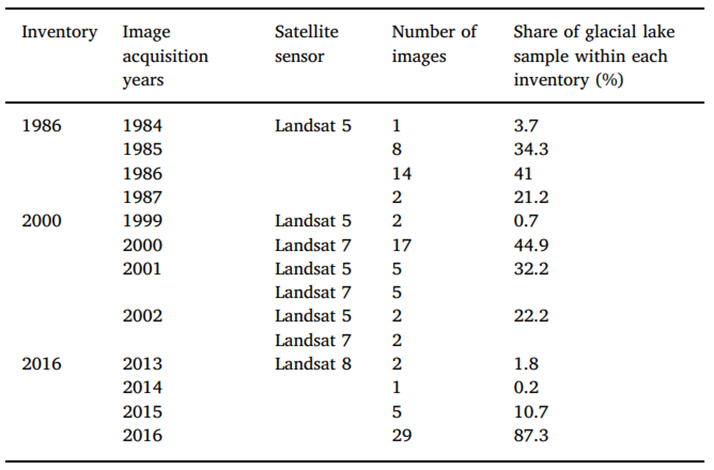

For this study only 2016 dataset is used, due to the fact that Sentinel-2 mission only started in 2015 and (possibly) this data is going to be used later. 

Here is representation of the data in QGIS:

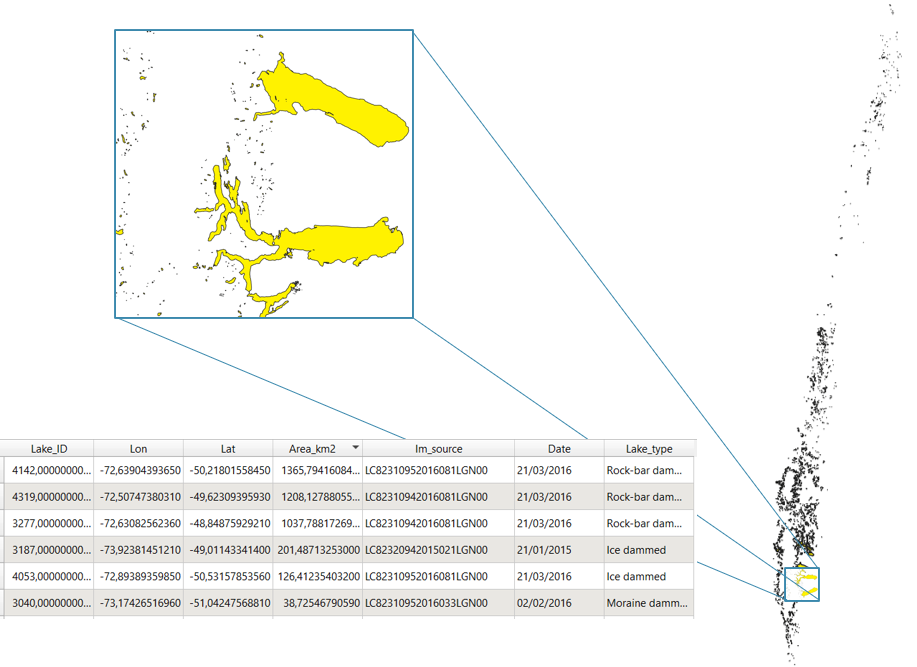

By the date, location, and Im_source in the original dataset, 37 images were manually found and downloaded from https://earthexplorer.usgs.gov/. Two images was further excluded during data cleaning process. In addition, the dataset above contained errors in Date and Im_source fields. The process of cleaning data and finding images is excluded from this description due to being extremely boring. 

Superimposed shapefile with lakes and Landsat 8-9 Band 2 Blue (grayscale):

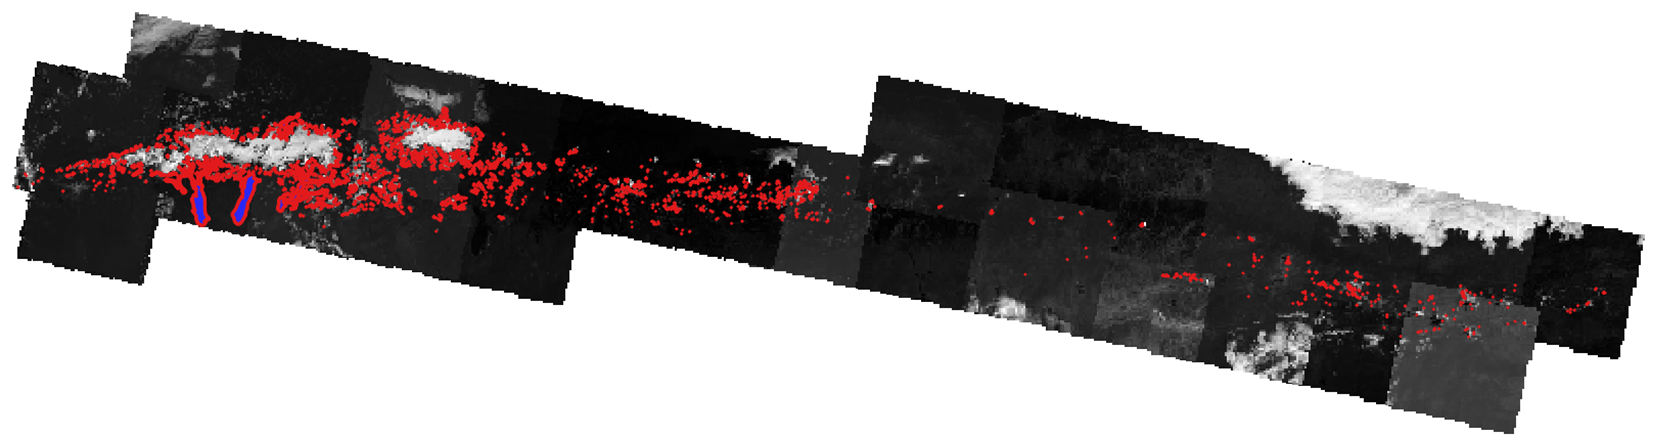

The following problems were found during data preprocessing in QGIS:

1. There are 26 'spots' and 36 images, therefore for the same 'spot' there are sometimes several images of different dates. Due to this, some lakes might be not mapped to the image even if they are on it, since they would be mapped to the image from another date. 

2. Only glacier lakes are contained in the dataset, however, not only glacier lakes are on the images. 

The solution for this problems is going to be represented below. 

## Reorganizing of the folders

In the uploaded data, the following folders correspond to the folders in the code:

- original images = images
- original labels = labels

Contained in the folder train_test_data:
- images = cropped_images
- labels = cropped_labels

Original Landsat data (South America folder) is not included since every image weights about 1Gb. 

## Landsat 8-9 obtaining RGB image by combining bands

When downloading images from https://earthexplorer.usgs.gov/, there are multiple files, including different bands. In order to obtain an RGB image, it is necessary to combine bands (2 - blue, 3 - green, 4 - red)). 

They need to be unpacked into folder, and this folder has to be placed in the folder which is going to be our 'path_input' (So we have some folder images - our `path_input`, which contains folder LC08_L2SP_231093_20160202_20200907_02_T1, and this one contains all the files related to this image). This is made in order to implement multiple images generation. 

Then, the function `combining_bands(path_input, path_output)`, should be called. `path_output` is the folder where you want your RGB images to be uploaded. 

In [ ]:
def combining_bands(path_input, path_output):
    directory = os.fsencode(path_input)
    folders = []
    for i in range(len(os.listdir(directory))):
        folders.append(os.fsdecode(os.listdir(directory)[i]))  

    for i in range(len(folders)):
        d = os.fsencode(path_input + folders[i])
        filename = str(os.fsdecode(os.listdir(d)[0])[:40])
        blue = rasterio.open(path_input + folders[i] + '/' + filename + '_SR_B2.TIF')
        green = rasterio.open(path_input + folders[i] + '/' + filename + '_SR_B3.TIF')
        red = rasterio.open(path_input + folders[i] + '/' + filename + '_SR_B4.TIF')
        with rasterio.open(path_output + filename + '.tif','w',driver='Gtiff', width=blue.width, height=blue.height, count=3, crs=blue.crs,transform=blue.transform, dtype=blue.dtypes[0]) as rgb:
            rgb.write(blue.read(1),3) 
            rgb.write(green.read(1),2) 
            rgb.write(red.read(1),1) 
            rgb.close()


In [ ]:
combining_bands('../data/South America/', 'output/')

## Creating labels

On the next step, the images were renamed to correspond to the Im_source in the original dataset. For each image, a separate shapefile was generated in QGIS by filtering by the Im_source. 

Then the shapefiles were transformed to tiff file corresponding to the image using R code (see shp_to_tiff.Rmd). The result is represented below:

In [8]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def show_image(path, rgb=True):
    img = rasterio.open(path)
    if rgb:
        red = img.read(1)
        green = img.read(2)
        blue = img.read(3)
        return np.dstack((normalize(red), normalize(green), normalize(blue)))
    else:
        return normalize(img.read(1))




(-0.5, 8090.5, 8090.5, -0.5)

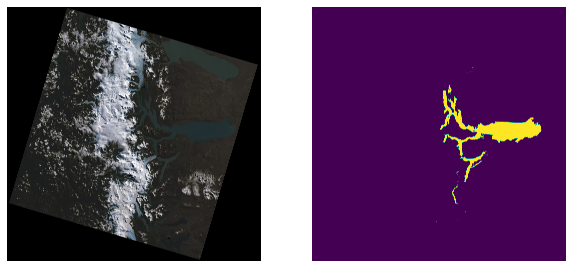

In [32]:
img = show_image('../data/images/LC82310952016081LGN00.tif')
lbl = show_image('../data/labels/LC82310952016081LGN00.tiff', rgb=False)

# Let's see how our color composite looks like
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")
ax = plt.subplot(1,2,2)
plt.imshow(lbl)
plt.axis("off")

## Image Patching

Since we are going to perform multi-resolution image segmentation and the task is to see if it is possible to achieve high accuracy for the lakes significantly different in size, we are inititally going to patch the data to the images of the size 1024x1024 (for better representation of the bigger lakes). 

Here are also implemented the solutions for the problems described in the Dataset Overview section. 

To solve the problem of lakes being not glacier, therefore not mapped in the original dataset, a mask of the South America glacier with extended by 5 kilometers border was designed in QGIS. The input image is being overlapped with this mask. 

Masked image is looking like this:

(-0.5, 8160.5, 8180.5, -0.5)

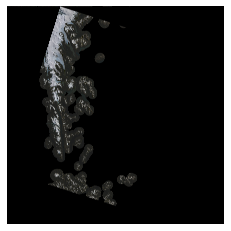

In [34]:
img_masked = show_image('../data/images/masked_images/LC82300962013353LGN00_mask.tif')
plt.imshow(img_masked)
plt.axis("off")

Since we have a lot of cases when the lakes are actually on the image but not on the label, we are going to remove from the dataset those patches that have no 'lake' pixels on the label. 

The code for performing the image patching is represented below. 

In [4]:
class image_preprocessing:
    #initializing the class
    def __init__(self, img_folder, img_output_folder, mask_path, label_folder = '', label_output_folder = '', training=False):
        self.img_input = img_folder #path to the image folder
        self.img_output = img_output_folder #path to a folder where the images for training/testing should be
        self.lbl_input = label_folder #path to the label folder if training = True
        self.lbl_output = label_output_folder #path to the folder where the output lables should be
        self.mask_path = mask_path #path to the mask of a glacier by which the image should be cropped
        #we need to distinguish between images that are for training and those that are for testing
        self.training = training
    
    def make_overlapped(self):
        for file in os.listdir(self.img_input):
            self.image_mask_overlapping(file)
        

    #input: img_path - path to a specific image
    #the function performs overlapping the images with the mask of the glacier
    def image_mask_overlapping(self, filename):
        print(filename + ' in process')
        with rasterio.open(self.img_input + filename) as src:
            # Read the image data
            img = src.read()
            # Open the shapefile
            shapefile = gpd.read_file(self.mask_path)
            
            # Crop the image to the shapefile's geometry
            out_img, out_transform = mask(src, shapes=shapefile.geometry, crop=True)
            # Get the number of bands of the source data
            src_bands = src.count
            # Get the number of bands of the output image
            out_bands = out_img.shape[0]
            # Check if the number of bands of the source data and the output image match
            if src_bands != out_bands:
                # If not, raise an error
                raise ValueError("Number of bands of the source data and the output image do not match")
            # Update the metadata for the new image
            out_meta = src.meta.copy()
            out_meta.update({"driver": "GTiff",
                            "height": out_img.shape[2],
                            "width": out_img.shape[1],
                            "count": out_img.shape[0],
                            "transform": src.transform, 
                            "dtype" : out_img.dtype,
                            "crs" : src.crs})
            # Save the new image

            # We don't actually need to save these, maybe delete later
            with rasterio.open('../data/images_masked/' + filename[:-4] + '_mask.tif', 'w', driver='GTiff',
                                       width=img.shape[1], height=img.shape[2], count=out_img.shape[0], dtype=out_img.dtype,
                                       crs=src.crs, transform=src.transform) as dst:
                dst.write(out_img)


    def crop_img_lbl(self, size=512):
        for file in os.listdir(self.img_input):
            if (file[:-4] + '_mask.tif') not in os.listdir('../data/images_masked/'):
                img = self.image_mask_overlapping(file)
            with rasterio.open('../data/images_masked/' + file[:-4] + '_mask.tif') as src, rasterio.open(self.lbl_input + file + 'f') as label:
                # Read the image and label data
                img_data = src.read()
                label_data = label.read(1)
                width, height = img_data.shape[1], img_data.shape[2]
                for i in range(0, width, size):
                    for j in range(0, height, size):
                        img_patch = img_data[:, i:i+size, j:j+size]
                        label_patch = label_data[i:i+size, j:j+size]
                        # Check if there are any pixels equal to 1 in the label patch
                        if np.any(label_patch == 1):
                            # Save the image and label patch
                            with rasterio.open(self.img_output + '{}_{}_{}.tif'.format(file[:-4], i, j), 'w', driver='GTiff',
                                            width=size, height=size, count=img_data.shape[0], dtype=img_data.dtype,
                                            crs=src.crs, transform=src.transform) as dst:
                                dst.write(img_patch)
                            with rasterio.open(self.lbl_output + '{}_{}_{}.tiff'.format(file[:-4], i, j), 'w', driver='GTiff',
                                            width=size, height=size, count=1, dtype=label_patch.dtype,
                                            crs=src.crs, transform=src.transform) as dst:
                                dst.write(label_patch, 1)

In [22]:
im_prep = image_preprocessing('../data/images/', '../data/cropped_images/', '../data/glacier_mask/mask.shp', '../data/labels/', '../data/cropped_labels/')
im_prep.crop_img_lbl(size=1024)

During this process, 360 images of the size 1024x1024 and their labels were obtained. 